In [41]:
# Import necessary libraries: pandas, numpy, matplotlib, and yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Step 1: Load the data
# Load the data from yfinance into a pandas DataFrame

# Download Amazon stock data for the past 6 months
ticker = yf.Ticker("AMZN")
end_date = datetime.now().strftime('%Y-%m-%d')
data = ticker.history(start='2022-01-01',end=end_date)



# Preview the data to ensure it's loaded correctly! (Hint: print it)
print(data['Close'].head())

Date
2022-01-03 00:00:00-05:00    170.404495
2022-01-04 00:00:00-05:00    167.522003
2022-01-05 00:00:00-05:00    164.356995
2022-01-06 00:00:00-05:00    163.253998
2022-01-07 00:00:00-05:00    162.554001
Name: Close, dtype: float64


In [42]:

# Step 2: Data Cleaning

# Flatten MultiIndex columns by taking only the first level
data.columns = data.columns.get_level_values(0)

# Check the columns to confirm they have been flattened
print("Flattened columns:", list(data.columns))

# Drop rows with missing data in required columns
required_columns = ['High', 'Low', 'Close', 'Volume']
data = data.dropna(subset=required_columns)



Flattened columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


In [43]:

# Step 3: Strategy: Money Flow Index

# Function to calculate Money Flow Index (MFI)
def calculate_mfi(data, n):
    data.columns = data.columns.get_level_values(0)  # Flatten MultiIndex columns
    print(data)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    print (typical_price)
    money_flow = typical_price * data['Volume']
    
    # Calculate positive and negative money flow
    positive_mf = []
    negative_mf = []
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i - 1]:
            positive_mf.append(money_flow[i])
            negative_mf.append(0)
        else:
            positive_mf.append(0)
            negative_mf.append(money_flow[i])

    positive_mf = pd.Series(positive_mf, index=data.index[1:])
    negative_mf = pd.Series(negative_mf, index=data.index[1:])
    
    pos_mf_rolling = positive_mf.rolling(window=n).sum()
    neg_mf_rolling = negative_mf.rolling(window=n).sum()
    mfi = 100 * (pos_mf_rolling / (pos_mf_rolling + neg_mf_rolling.replace({0: np.nan})))
    
    data['MFI'] = np.nan
    data.loc[positive_mf.index, 'MFI'] = mfi
    return data
data = calculate_mfi(data, 28)
data = calculate_mfi(data, 14)





                                 Open        High         Low       Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  167.550003  170.703506  166.160507  170.404495   
2022-01-04 00:00:00-05:00  170.438004  171.399994  166.349503  167.522003   
2022-01-05 00:00:00-05:00  166.882996  167.126495  164.356995  164.356995   
2022-01-06 00:00:00-05:00  163.450500  164.800003  161.936996  163.253998   
2022-01-07 00:00:00-05:00  163.839005  165.243500  162.031006  162.554001   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00-05:00  196.449997  197.330002  194.309998  195.779999   
2024-11-05 00:00:00-05:00  196.039993  199.820007  195.990005  199.500000   
2024-11-06 00:00:00-05:00  200.009995  207.550003  199.139999  207.089996   
2024-11-07 00:00:00-05:00  207.440002  212.250000  207.190002  210.050003   
2024-11-08 00:00:00-05:00  209.720001  209.960007  207.440002  208.179993   

C:\Users\ishaa\AppData\Local\Temp\ipykernel_116720\365197512.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if typical_price[i] > typical_price[i - 1]:
C:\Users\ishaa\AppData\Local\Temp\ipykernel_116720\365197512.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_mf.append(money_flow[i])
C:\Users\ishaa\AppData\Local\Temp\ipykernel_116720\365197512.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_mf.appe

In [ ]:
# Step 4: signals
# now we must create signals for activity
# when the VIX column is true, the signal sohuld be NULL
# when the VIX column is false, price>st_linreg, and lt_linreg(n)>lt_linreg(n-1), generate a buy signal
# VIX = false, and lt_linreg(n)<lt_linreg(n-1) OR st_linreg(n)<stLlinreg(n-1), generate a sell signal
def generate_signals(data):
  oversold_threshold = 20
  overbought_threshold = 80

  # Generate signals: 1 = buy, -1 = sell, 0 = hold
  data['Signal'] = 0
  data['Signal'] = np.where(data['MFI'] < oversold_threshold, 1, data['Signal'])   # Buy signal
  data['Signal'] = np.where(data['MFI'] > overbought_threshold, -1, data['Signal'])  # Sell signal
  
  # Calculate daily returns
  data['Market_Return'] = data['Close'].pct_change()
  # Implement MFI strategy by simulating trades
  data['Position'] = data['Signal'].replace(to_replace=0, method='ffill').shift().fillna(0)
  data['Strategy_Return'] = data['Position'] * data['Market_Return']

  # Calculate cumulative returns for strategy and buy-and-hold
  data['Strategy_Cumulative'] = (1 + data['Strategy_Return']).cumprod()
  data['Market_Cumulative'] = (1 + data['Market_Return']).cumprod()

  return data

data = generate_signals(data)

C:\Users\ishaa\AppData\Local\Temp\ipykernel_116720\3347964219.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Signal'].replace(to_replace=0, method='ffill').shift().fillna(0)


**For the future**

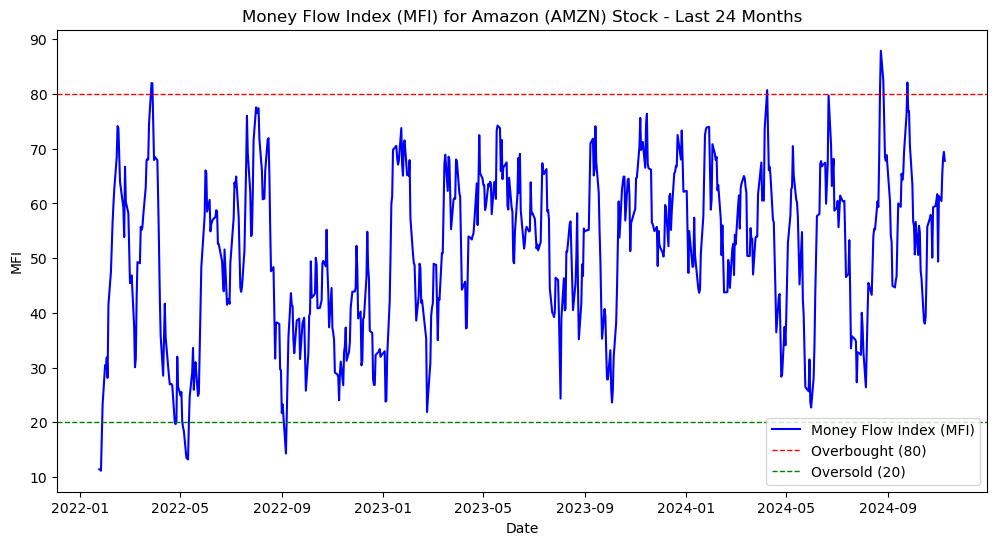

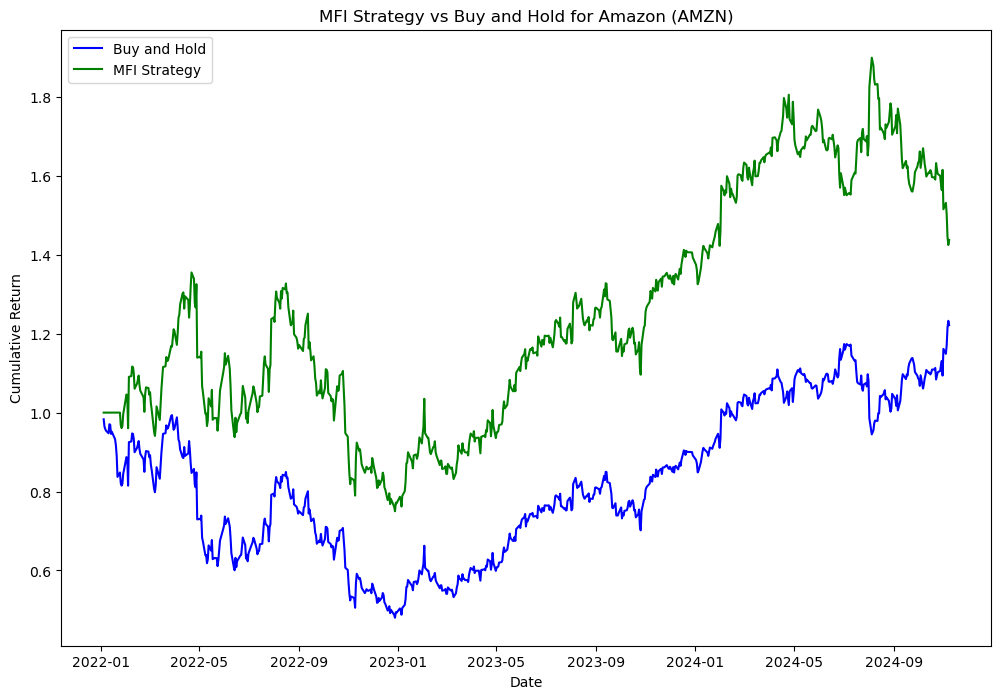

In [45]:

# Step 5: Backtesting the Strategy
# --------------------------------
# Now that we have buy and sell signals, let's simulate a basic backtesting approach.
# The goal is to see how the strategy performs by calculating returns.



# Step 6: Visualizing the Results
# -------------------------------


def plot_data(data):

    # Plot the MFI for Amazon stock over the past 6 months
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['MFI'], label='Money Flow Index (MFI)', color='blue')
    plt.axhline(80, color='red', linestyle='dashed', linewidth=1, label='Overbought (80)')
    plt.axhline(20, color='green', linestyle='dashed', linewidth=1, label='Oversold (20)')
    plt.title('Money Flow Index (MFI) for Amazon (AMZN) Stock - Last 24 Months')
    plt.xlabel('Date')
    plt.ylabel('MFI')
    plt.legend()
    plt.show()

# Plot the results
plot_data(data)

# Plot the cumulative returns of the strategy vs. the market
def plot_returns(data):
    # Plot the MFI strategy vs. Buy-and-Hold performance
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Market_Cumulative'], label="Buy and Hold", color="blue")
    plt.plot(data.index, data['Strategy_Cumulative'], label="MFI Strategy", color="green")
    plt.title('MFI Strategy vs Buy and Hold for Amazon (AMZN)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

# Plot strategy vs market returns
plot_returns(data)

# Unable to figure out why the MFI is flat for the first while, thus the bigger interval.
